In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm
import seaborn as sns
import pickle
import os
from IGT.environments import IGTEnv, NonStochasticBanditEnv, NonStationaryEnv
from IGT.train import train
import threading
import concurrent.futures

## Hyperparameters for Parameter Sweep

In [2]:
# Base hyperparameters
trails = 200
epochs = 1  # Reduced for faster execution while looping
bins = 10
lr = 0.1
num_arms = 2
scaling_factor = 100
time_stamp_change = 100
stationary = False
window_size = 20  # Bin size for analyzing arm probabilities

# Define reward values for each arm
reward_values = np.array([40, 40])/scaling_factor
reward_std = np.array([1, 1])/scaling_factor

# Define initial probabilities for each arm
initial_probabilities = np.array([0.8, 0.2])

# Define changed reward values (after time_stamp_change)
reward_values_changed = np.array([40, 40])/scaling_factor
reward_std_changed = np.array([1, 1])/scaling_factor

# Define changed probabilities (after time_stamp_change)
changed_probabilities = np.array([0.2, 0.8])

# Set which parameters to change: 'reward', 'probability', or 'both'
change_type = 'probability'

# Parameters to vary
del_lim_values = np.linspace(0, 1, 20)  # 20 points from 0 to 1
var_values = np.linspace(0, 1, 20)      # 20 points from 0 to 1

# Results dictionary
results = {
    'del_lim': {},
    'var': {}
}

## Helper Functions for Data Analysis

In [3]:
def get_arm_probabilities_over_time(arm_chosen_monitor, num_arms, trails, epochs, window_size):
    """
    Calculate the probability of choosing each arm in time windows.
    
    Parameters:
    -----------
    arm_chosen_monitor: Tensor
        The monitor of chosen arms for each epoch and trial
    num_arms: int
        Number of arms in the bandit
    trails: int
        Number of trials
    epochs: int
        Number of epochs
    window_size: int
        Size of the time window for analysis
        
    Returns:
    --------
    dict: Dictionary with arm probabilities over time windows
    """
    num_windows = trails // window_size
    
    # Initialize array to store probabilities for each window
    arm_probs_over_time = {arm: np.zeros(num_windows) for arm in range(num_arms)}
    window_centers = [(i + 0.5) * window_size for i in range(num_windows)]
    
    # Calculate probability of choosing each arm in each time window
    for epoch in range(epochs):
        for window_idx in range(num_windows):
            start_idx = window_idx * window_size
            end_idx = start_idx + window_size
            
            # Count occurrences of each arm in this window
            window_counts = {arm: 0 for arm in range(num_arms)}
            valid_choices = 0
            
            for trial in range(start_idx, end_idx):
                if trial < trails:
                    arm = arm_chosen_monitor[epoch][trial].item()
                    if arm < num_arms:  # Only count valid arms
                        window_counts[arm] += 1
                        valid_choices += 1
            
            # Calculate probabilities for this window
            if valid_choices > 0:
                for arm in range(num_arms):
                    arm_probs_over_time[arm][window_idx] += window_counts[arm] / valid_choices
    
    # Average across epochs
    for arm in range(num_arms):
        arm_probs_over_time[arm] /= epochs
    
    # Find indices for pre-change and post-change
    change_window_idx = next((i for i, center in enumerate(window_centers) if center > time_stamp_change), None)
    
    # Calculate average arm probabilities before and after change
    arm_probs_pre_change = {arm: np.mean(arm_probs_over_time[arm][:change_window_idx]) 
                           for arm in range(num_arms)} if change_window_idx else {}
    arm_probs_post_change = {arm: np.mean(arm_probs_over_time[arm][change_window_idx:]) 
                            for arm in range(num_arms)} if change_window_idx else {}
    
    return {
        'probs': arm_probs_over_time,
        'window_centers': window_centers,
        'pre_change': arm_probs_pre_change,
        'post_change': arm_probs_post_change,
        'change_window_idx': change_window_idx
    }

def calculate_adaptation_time(arm_probs_over_time, window_centers, time_stamp_change):
    """
    Calculate the time it takes for the agent to adapt after environment change.
    Adaptation is defined as when arm 1's selection probability exceeds arm 0's.
    
    Parameters:
    -----------
    arm_probs_over_time: dict
        Dictionary with arm probabilities over time
    window_centers: list
        Centers of time windows
    time_stamp_change: int
        Trial number when the environment changes
        
    Returns:
    --------
    dict: Dictionary with adaptation metrics
    """
    adaptation_window = None
    for i in range(len(window_centers)):
        window_center = window_centers[i]
        if window_center > time_stamp_change and arm_probs_over_time[1][i] > arm_probs_over_time[0][i]:
            adaptation_window = i
            break
    
    if adaptation_window is not None:
        adaptation_trial = window_centers[adaptation_window]
        adaptation_time = adaptation_trial - time_stamp_change
        return {
            'adapted': True,
            'adaptation_trial': adaptation_trial,
            'adaptation_time': adaptation_time
        }
    else:
        return {
            'adapted': False,
            'adaptation_trial': None,
            'adaptation_time': None
        }

## Parameter Sweep: 2D grid of del_lim and var values (400 points total)

In [4]:
# Initialize a nested dictionary for 2D results
results_2d = {}

# Pre-change and post-change probability matrices for heatmaps
arm0_pre_matrix = np.zeros((len(del_lim_values), len(var_values)))
arm0_post_matrix = np.zeros((len(del_lim_values), len(var_values)))
arm1_pre_matrix = np.zeros((len(del_lim_values), len(var_values)))
arm1_post_matrix = np.zeros((len(del_lim_values), len(var_values)))

# Create a progress bar for the full 400 combinations
total_combinations = len(del_lim_values) * len(var_values)
print(f"Processing a total of {total_combinations} parameter combinations: {len(del_lim_values)} del_lim values × {len(var_values)} var values")

# Initialize results structure with empty dictionaries
for del_lim in del_lim_values:
    results_2d[del_lim] = {}

# Import threading modules
import threading
import queue
from concurrent.futures import ThreadPoolExecutor

# Thread lock for data structures
result_lock = threading.Lock()

# Function to process one parameter combination
def process_parameter_combination(args):
    i, del_lim, j, var = args
    
    # Create environment
    env = NonStationaryEnv(
        num_arms=num_arms,
        mean_reward=reward_values,
        std=reward_std,
        probabilities=initial_probabilities,
        mean_rew_change=reward_values_changed,
        std_change=reward_std_changed,
        probabilities_change=changed_probabilities,
        stationary=stationary,
        time_stamp_change=time_stamp_change,
        change_type=change_type
    )
    
    # Train model with current parameter combination
    reward_monitor, arm_chosen_monitor, avg_counts, ip_monitor, dp_monitor, _ = train(
        env,
        trails=trails,
        epochs=epochs,
        lr=lr,
        bins=bins,
        STN_spike_output=None,
        d1_amp=0.5,
        d2_amp=0.3,
        gpi_threshold=0.2,
        max_gpi_iters=50,
        STN_neurons=256,
        stn_mean=0,
        stn_std=0,
        del_lim=del_lim,  # Varied parameter 1
        train_IP=False,
        del_med=None,
        printing=False,  # Turn off printing for loop
        gpi_mean=1,
        gpi_var=var  # Varied parameter 2
    )
    
    # Calculate arm probabilities over time
    arm_probs_data = get_arm_probabilities_over_time(
        arm_chosen_monitor, num_arms, trails, epochs, window_size
    )
    
    # Calculate adaptation time
    adaptation_data = calculate_adaptation_time(
        arm_probs_data['probs'], 
        arm_probs_data['window_centers'], 
        time_stamp_change
    )
    
    # Store results (thread-safe)
    with result_lock:
        # Store in main results dictionary
        results_2d[del_lim][var] = {
            'arm_probs': arm_probs_data['probs'],
            'window_centers': arm_probs_data['window_centers'],
            'adaptation': adaptation_data,
            'pre_change': arm_probs_data['pre_change'],
            'post_change': arm_probs_data['post_change']
        }
        
        # Fill matrices for heatmaps - ensure correct indexing
        if 0 in arm_probs_data['pre_change']:
            arm0_pre_matrix[i, j] = arm_probs_data['pre_change'][0]
            arm0_post_matrix[i, j] = arm_probs_data['post_change'][0]
        
        if 1 in arm_probs_data['pre_change']:
            arm1_pre_matrix[i, j] = arm_probs_data['pre_change'][1]
            arm1_post_matrix[i, j] = arm_probs_data['post_change'][1]

# Create all parameter combinations
parameter_combinations = [(i, del_lim, j, var) 
                         for i, del_lim in enumerate(del_lim_values) 
                         for j, var in enumerate(var_values)]

print(f"First few combinations to process: {parameter_combinations[:5]}")
print(f"Last few combinations to process: {parameter_combinations[-5:]}")

# Ensure all combinations are processed
assert len(parameter_combinations) == total_combinations, "Mismatch in total combinations to process"

# Set the number of threads to use (adjust based on your system)
max_suggested_threads = min(32, threading.active_count() * 4)
num_threads = min(max_suggested_threads, total_combinations)  # Don't use more threads than combinations
print(f"Using {num_threads} parallel threads for processing")

# Process combinations using a thread pool
with tqdm(total=total_combinations, desc="Parameter combinations") as pbar:
    # Using ThreadPoolExecutor to manage threads
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Submit all tasks to the executor
        futures = [executor.submit(process_parameter_combination, combo) for combo in parameter_combinations]
        
        # Process completed futures as they come in
        for future in concurrent.futures.as_completed(futures):
            # Check for any exceptions
            try:
                future.result()
            except Exception as exc:
                print(f"Task generated an exception: {exc}")
            # Update progress bar
            pbar.update(1)
            processed_count = pbar.n
            if processed_count < total_combinations:
                print(f"Warning: Only {processed_count}/{total_combinations} combinations processed so far.")
        assert processed_count == total_combinations, f"Not all combinations processed: {processed_count}/{total_combinations}"

# Verify matrices have been filled properly
print(f"Matrix shapes - arm0_pre_matrix: {arm0_pre_matrix.shape}, arm0_post_matrix: {arm0_post_matrix.shape}")
print(f"Non-zero entries in arm0_pre_matrix: {np.count_nonzero(arm0_pre_matrix)}/{arm0_pre_matrix.size}")
print(f"Non-zero entries in arm0_post_matrix: {np.count_nonzero(arm0_post_matrix)}/{arm0_post_matrix.size}")

# Save the full 2D results
output_file_2d = "param_sweep_2d_results.pkl"
with open(output_file_2d, 'wb') as f:
    pickle.dump(results_2d, f)

# Also save the heatmap matrices for easier access later
heatmap_data = {
    'arm0_pre': arm0_pre_matrix,
    'arm0_post': arm0_post_matrix,
    'arm1_pre': arm1_pre_matrix,
    'arm1_post': arm1_post_matrix,
    'del_lim_values': del_lim_values,
    'var_values': var_values
}

with open("arm_probability_heatmaps.pkl", 'wb') as f:
    pickle.dump(heatmap_data, f)

print(f"Full 2D parameter sweep results saved to {output_file_2d}")
print(f"Heatmap data saved to arm_probability_heatmaps.pkl")

Processing a total of 400 parameter combinations: 20 del_lim values × 20 var values
First few combinations to process: [(0, np.float64(0.0), 0, np.float64(0.0)), (0, np.float64(0.0), 1, np.float64(0.05263157894736842)), (0, np.float64(0.0), 2, np.float64(0.10526315789473684)), (0, np.float64(0.0), 3, np.float64(0.15789473684210525)), (0, np.float64(0.0), 4, np.float64(0.21052631578947367))]
Last few combinations to process: [(19, np.float64(1.0), 15, np.float64(0.7894736842105263)), (19, np.float64(1.0), 16, np.float64(0.8421052631578947)), (19, np.float64(1.0), 17, np.float64(0.894736842105263)), (19, np.float64(1.0), 18, np.float64(0.9473684210526315)), (19, np.float64(1.0), 19, np.float64(1.0))]
Using 24 parallel threads for processing


Parameter combinations:   0%|          | 0/400 [00:00<?, ?it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:   1%|          | 4/400 [00:36<46:02,  6.98s/it]  

Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:   2%|▏         | 9/400 [00:37<13:27,  2.07s/it]


Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:   4%|▍         | 17/400 [00:37<04:41,  1.36it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:   6%|▌         | 22/400 [00:37<03:05,  2.04it/s]


Using Random noise
Using Random noise
Using Random noise




Parameter combinations:   6%|▋         | 25/400 [01:11<19:11,  3.07s/it]

Using Random noise


Parameter combinations:   8%|▊         | 30/400 [01:11<10:57,  1.78s/it]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:   9%|▉         | 35/400 [01:11<06:35,  1.08s/it]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  10%|█         | 41/400 [01:12<03:39,  1.64it/s]


Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  11%|█         | 44/400 [01:12<02:45,  2.16it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  12%|█▏        | 48/400 [01:12<01:53,  3.10it/s]

Using Random noise


Parameter combinations:  12%|█▏        | 49/400 [01:45<22:36,  3.86s/it]

Using Random noise


Parameter combinations:  13%|█▎        | 52/400 [01:46<14:25,  2.49s/it]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  14%|█▍        | 55/400 [01:46<09:05,  1.58s/it]

Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  15%|█▍        | 59/400 [01:46<04:58,  1.14it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  17%|█▋        | 67/400 [01:46<01:48,  3.08it/s]


Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  18%|█▊        | 70/400 [01:46<01:23,  3.94it/s]


Using Random noise
Using Random noise


Parameter combinations:  18%|█▊        | 72/400 [01:47<01:11,  4.60it/s]

Using Random noise
Using Random noise


Parameter combinations:  18%|█▊        | 73/400 [02:19<24:52,  4.56s/it]

Using Random noise


Parameter combinations:  18%|█▊        | 74/400 [02:20<21:06,  3.89s/it]

Using Random noise
Using Random noise


Parameter combinations:  20%|█▉        | 79/400 [02:20<08:42,  1.63s/it]

Using Random noise
Using Random noise
Using Random noise
Using Random noise




Parameter combinations:  21%|██▏       | 85/400 [02:21<03:53,  1.35it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  22%|██▏       | 89/400 [02:21<02:25,  2.14it/s]


Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  24%|██▎       | 94/400 [02:21<01:23,  3.64it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise




Parameter combinations:  24%|██▍       | 96/400 [02:22<01:21,  3.75it/s]

Using Random noise


Parameter combinations:  24%|██▍       | 97/400 [02:54<23:54,  4.73s/it]

Using Random noise


Parameter combinations:  24%|██▍       | 98/400 [02:54<20:24,  4.06s/it]

Using Random noise


Parameter combinations:  25%|██▌       | 100/400 [02:55<14:21,  2.87s/it]


Using Random noise


Parameter combinations:  25%|██▌       | 101/400 [02:56<12:38,  2.54s/it]

Using Random noise


Parameter combinations:  26%|██▌       | 102/400 [02:56<10:12,  2.05s/it]

Using Random noise
Using Random noise


Parameter combinations:  26%|██▋       | 105/400 [02:57<05:17,  1.08s/it]

Using Random noise
Using Random noise


Parameter combinations:  26%|██▋       | 106/400 [02:57<04:15,  1.15it/s]

Using Random noise


Parameter combinations:  27%|██▋       | 108/400 [02:58<03:01,  1.61it/s]

Using Random noise
Using Random noise


Parameter combinations:  28%|██▊       | 112/400 [02:58<01:15,  3.79it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  28%|██▊       | 114/400 [02:58<00:59,  4.83it/s]

Using Random noise
Using Random noise


Parameter combinations:  29%|██▉       | 115/400 [02:58<00:56,  5.07it/s]

Using Random noise


Parameter combinations:  29%|██▉       | 116/400 [02:59<00:54,  5.21it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  30%|███       | 120/400 [02:59<00:46,  6.04it/s]

Using Random noiseWarning: Only 119/400 combinations processed so far.

Using Random noise


Parameter combinations:  30%|███       | 121/400 [03:38<38:11,  8.21s/it]

Using Random noise


Parameter combinations:  30%|███       | 122/400 [03:38<29:47,  6.43s/it]

Using Random noise


Parameter combinations:  31%|███       | 123/400 [03:39<23:06,  5.00s/it]

Using Random noise


Parameter combinations:  31%|███       | 124/400 [03:39<17:14,  3.75s/it]

Using Random noise


Parameter combinations:  31%|███▏      | 125/400 [03:40<13:26,  2.93s/it]

Using Random noise


Parameter combinations:  32%|███▏      | 129/400 [03:40<04:43,  1.05s/it]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  33%|███▎      | 132/400 [03:41<02:41,  1.66it/s]

Using Random noise
Using Random noise


Parameter combinations:  34%|███▎      | 134/400 [03:41<01:51,  2.39it/s]

Using Random noise
Using Random noise


Parameter combinations:  34%|███▍      | 136/400 [03:41<01:15,  3.49it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  34%|███▍      | 138/400 [03:41<00:51,  5.10it/s]

Using Random noise
Using Random noise


Parameter combinations:  35%|███▌      | 141/400 [03:42<00:49,  5.27it/s]

Using Random noise
Using Random noise


Parameter combinations:  36%|███▌      | 142/400 [03:42<00:49,  5.17it/s]

Using Random noise


Parameter combinations:  36%|███▌      | 144/400 [03:43<00:58,  4.35it/s]

Using Random noise
Using Random noise


Parameter combinations:  36%|███▋      | 145/400 [04:19<42:30, 10.00s/it]

Using Random noise


Parameter combinations:  36%|███▋      | 146/400 [04:19<31:09,  7.36s/it]

Using Random noise


Parameter combinations:  37%|███▋      | 147/400 [04:20<22:45,  5.40s/it]

Using Random noise


Parameter combinations:  37%|███▋      | 148/400 [04:20<16:22,  3.90s/it]

Using Random noise


Parameter combinations:  38%|███▊      | 150/400 [04:21<08:37,  2.07s/it]

Using Random noise
Using Random noise


Parameter combinations:  38%|███▊      | 151/400 [04:21<06:14,  1.51s/it]

Using Random noise
Using Random noise


Parameter combinations:  39%|███▉      | 155/400 [04:21<02:17,  1.78it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  39%|███▉      | 157/400 [04:21<01:37,  2.48it/s]


Using Random noise
Using Random noise


Parameter combinations:  40%|████      | 160/400 [04:22<00:58,  4.09it/s]


Using Random noise


Parameter combinations:  40%|████      | 162/400 [04:22<01:12,  3.30it/s]


Using Random noise


Parameter combinations:  41%|████      | 163/400 [04:23<01:08,  3.44it/s]

Using Random noise


Parameter combinations:  41%|████      | 164/400 [04:23<01:09,  3.37it/s]

Using Random noise


Parameter combinations:  41%|████▏     | 165/400 [04:23<01:12,  3.24it/s]

Using Random noise
Using Random noise


Parameter combinations:  42%|████▏     | 168/400 [04:24<01:08,  3.38it/s]

Using Random noise
Using Random noise


Parameter combinations:  42%|████▎     | 170/400 [04:58<23:34,  6.15s/it]

Using Random noise
Using Random noise


Parameter combinations:  43%|████▎     | 173/400 [04:59<10:07,  2.67s/it]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  44%|████▍     | 177/400 [04:59<04:01,  1.08s/it]

Using Random noise
Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  45%|████▍     | 179/400 [04:59<02:47,  1.32it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  46%|████▌     | 182/400 [05:00<01:58,  1.85it/s]

Using Random noiseWarning: Only 181/400 combinations processed so far.

Using Random noise
Using Random noise




Parameter combinations:  46%|████▋     | 185/400 [05:01<01:24,  2.55it/s]

Using Random noise


Parameter combinations:  47%|████▋     | 187/400 [05:01<01:15,  2.84it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  47%|████▋     | 188/400 [05:02<01:12,  2.94it/s]

Using Random noise


Parameter combinations:  48%|████▊     | 190/400 [05:02<00:55,  3.79it/s]

Using Random noise
Using Random noise


Parameter combinations:  48%|████▊     | 191/400 [05:03<01:34,  2.22it/s]

Using Random noise
Using Random noise


Parameter combinations:  48%|████▊     | 193/400 [05:34<24:10,  7.01s/it]

Using Random noise


Parameter combinations:  49%|████▉     | 196/400 [05:35<11:10,  3.29s/it]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  49%|████▉     | 197/400 [05:35<08:43,  2.58s/it]

Using Random noise
Using Random noise


Parameter combinations:  50%|████▉     | 199/400 [05:35<05:27,  1.63s/it]

Using Random noiseWarning: Only 199/400 combinations processed so far.



Parameter combinations:  50%|█████     | 200/400 [05:36<04:29,  1.35s/it]

Using Random noise


Parameter combinations:  50%|█████     | 202/400 [05:36<02:49,  1.17it/s]

Using Random noiseWarning: Only 201/400 combinations processed so far.

Using Random noise


Parameter combinations:  51%|█████     | 204/400 [05:37<01:54,  1.72it/s]

Using Random noise
Using Random noise


Parameter combinations:  51%|█████▏    | 205/400 [05:37<01:43,  1.89it/s]

Using Random noise


Parameter combinations:  52%|█████▏    | 207/400 [05:37<01:06,  2.91it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  52%|█████▏    | 209/400 [05:38<00:57,  3.33it/s]

Using Random noise


Parameter combinations:  53%|█████▎    | 211/400 [05:38<00:56,  3.33it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  54%|█████▎    | 214/400 [05:39<00:44,  4.15it/s]

Using Random noise
Using Random noise


Parameter combinations:  54%|█████▍    | 216/400 [05:40<01:06,  2.75it/s]

Using Random noise
Using Random noise


Parameter combinations:  55%|█████▍    | 218/400 [06:10<18:10,  5.99s/it]

Using Random noise
Using Random noise


Parameter combinations:  55%|█████▍    | 219/400 [06:10<13:20,  4.42s/it]

Using Random noise


Parameter combinations:  55%|█████▌    | 220/400 [06:11<09:46,  3.26s/it]

Using Random noiseWarning: Only 220/400 combinations processed so far.



Parameter combinations:  55%|█████▌    | 221/400 [06:11<07:16,  2.44s/it]

Using Random noise


Parameter combinations:  56%|█████▌    | 222/400 [06:11<05:22,  1.81s/it]

Using Random noise
Using Random noise


Parameter combinations:  56%|█████▌    | 223/400 [06:12<03:55,  1.33s/it]

Parameter combinations:  56%|█████▋    | 225/400 [06:12<02:23,  1.22it/s]

Using Random noise
Using Random noise


Parameter combinations:  56%|█████▋    | 226/400 [06:12<01:50,  1.58it/s]

Using Random noise


Parameter combinations:  57%|█████▋    | 227/400 [06:13<01:41,  1.71it/s]

Using Random noise


Parameter combinations:  57%|█████▋    | 229/400 [06:13<01:05,  2.59it/s]

Using Random noise
Using Random noise


Parameter combinations:  58%|█████▊    | 231/400 [06:14<00:47,  3.59it/s]

Using Random noise
Using Random noise


Parameter combinations:  58%|█████▊    | 232/400 [06:14<00:59,  2.81it/s]

Using Random noise


Parameter combinations:  59%|█████▉    | 235/400 [06:15<00:38,  4.28it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  59%|█████▉    | 237/400 [06:15<00:38,  4.20it/s]

Using Random noise
Using Random noise


Parameter combinations:  60%|█████▉    | 238/400 [06:16<00:46,  3.51it/s]

Using Random noise
Using Random noise


Parameter combinations:  60%|██████    | 240/400 [06:17<00:53,  2.97it/s]

Using Random noise


Parameter combinations:  60%|██████    | 241/400 [06:47<19:49,  7.48s/it]

Using Random noise
Using Random noise


Parameter combinations:  61%|██████    | 243/400 [06:48<11:59,  4.58s/it]

Using Random noise


Parameter combinations:  61%|██████    | 244/400 [06:48<09:29,  3.65s/it]

Using Random noise


Parameter combinations:  62%|██████▏   | 246/400 [06:49<05:41,  2.22s/it]

Using Random noise
Using Random noise


Parameter combinations:  62%|██████▏   | 247/400 [06:49<04:21,  1.71s/it]

Using Random noise


Parameter combinations:  62%|██████▏   | 248/400 [06:50<03:25,  1.35s/it]

Using Random noise


Parameter combinations:  62%|██████▏   | 249/400 [06:50<02:37,  1.04s/it]

Using Random noise


Parameter combinations:  62%|██████▎   | 250/400 [06:50<02:11,  1.14it/s]

Using Random noise


Parameter combinations:  63%|██████▎   | 252/400 [06:51<01:18,  1.89it/s]

Using Random noise
Using Random noise


Parameter combinations:  63%|██████▎   | 253/400 [06:51<01:07,  2.16it/s]

Using Random noise
Using Random noise


Parameter combinations:  64%|██████▍   | 256/400 [06:51<00:41,  3.47it/s]

Using Random noise
Using Random noise


Parameter combinations:  64%|██████▍   | 258/400 [06:52<00:29,  4.75it/s]

Using Random noise
Using Random noise


Parameter combinations:  65%|██████▌   | 260/400 [06:52<00:36,  3.79it/s]

Using Random noise
Using Random noise


Parameter combinations:  65%|██████▌   | 261/400 [06:53<00:47,  2.92it/s]

Using Random noise


Parameter combinations:  66%|██████▌   | 262/400 [06:54<00:59,  2.33it/s]

Using Random noise
Using Random noise


Parameter combinations:  66%|██████▌   | 264/400 [06:55<00:58,  2.32it/s]

Using Random noise


Parameter combinations:  66%|██████▋   | 265/400 [07:24<16:45,  7.44s/it]

Using Random noise


Parameter combinations:  66%|██████▋   | 266/400 [07:25<12:53,  5.77s/it]

Using Random noise


Parameter combinations:  67%|██████▋   | 267/400 [07:26<09:32,  4.30s/it]

Using Random noise
Using Random noise


Parameter combinations:  67%|██████▋   | 269/400 [07:26<05:31,  2.53s/it]

Using Random noise


Parameter combinations:  68%|██████▊   | 271/400 [07:27<03:24,  1.59s/it]

Using Random noise
Using Random noise


Parameter combinations:  68%|██████▊   | 273/400 [07:27<02:07,  1.00s/it]

Using Random noise
Using Random noise


Parameter combinations:  69%|██████▉   | 275/400 [07:28<01:17,  1.62it/s]

Using Random noise
Using Random noise


Parameter combinations:  69%|██████▉   | 277/400 [07:28<00:46,  2.64it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  70%|██████▉   | 279/400 [07:28<00:30,  3.92it/s]

Using Random noise
Using Random noise


Parameter combinations:  70%|███████   | 281/400 [07:29<00:44,  2.69it/s]

Using Random noise
Using Random noise


Parameter combinations:  71%|███████   | 283/400 [07:30<00:37,  3.11it/s]

Using Random noise
Using Random noise


Parameter combinations:  71%|███████▏  | 285/400 [07:30<00:32,  3.55it/s]

Using Random noise


Parameter combinations:  72%|███████▏  | 286/400 [07:31<00:45,  2.51it/s]

Using Random noise


Parameter combinations:  72%|███████▏  | 287/400 [07:31<00:40,  2.76it/s]

Using Random noise


Parameter combinations:  72%|███████▏  | 288/400 [07:32<00:55,  2.04it/s]

Using Random noise


Parameter combinations:  72%|███████▏  | 289/400 [08:01<14:07,  7.64s/it]

Using Random noise


Parameter combinations:  72%|███████▎  | 290/400 [08:03<10:58,  5.98s/it]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  74%|███████▍  | 295/400 [08:04<03:27,  1.98s/it]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  74%|███████▍  | 296/400 [08:04<02:50,  1.64s/it]

Using Random noise
Using Random noise


Parameter combinations:  75%|███████▍  | 299/400 [08:05<01:38,  1.03it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  75%|███████▌  | 301/400 [08:05<01:16,  1.29it/s]

Using Random noise
Using Random noise


Parameter combinations:  76%|███████▌  | 303/400 [08:06<00:57,  1.70it/s]

Using Random noise


Parameter combinations:  76%|███████▌  | 304/400 [08:06<00:51,  1.88it/s]

Using Random noise


Parameter combinations:  76%|███████▋  | 305/400 [08:07<00:48,  1.98it/s]

Using Random noise


Parameter combinations:  76%|███████▋  | 306/400 [08:07<00:47,  1.99it/s]

Using Random noise
Using Random noise


Parameter combinations:  77%|███████▋  | 307/400 [08:07<00:39,  2.34it/s]

Using Random noise


Parameter combinations:  77%|███████▋  | 309/400 [08:08<00:37,  2.45it/s]

Using Random noise


Parameter combinations:  78%|███████▊  | 310/400 [08:09<00:43,  2.06it/s]

Using Random noiseWarning: Only 310/400 combinations processed so far.



Parameter combinations:  78%|███████▊  | 311/400 [08:09<00:43,  2.04it/s]

Using Random noise


Parameter combinations:  78%|███████▊  | 312/400 [08:10<00:49,  1.79it/s]

Using Random noise


Parameter combinations:  78%|███████▊  | 313/400 [08:42<13:07,  9.05s/it]

Using Random noise


Parameter combinations:  78%|███████▊  | 314/400 [08:43<09:35,  6.70s/it]

Using Random noise


Parameter combinations:  79%|███████▉  | 316/400 [08:43<04:56,  3.53s/it]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  80%|███████▉  | 318/400 [08:43<02:43,  1.99s/it]

Using Random noise


Parameter combinations:  80%|███████▉  | 319/400 [08:44<02:14,  1.66s/it]

Using Random noise
Using Random noise


Parameter combinations:  80%|████████  | 321/400 [08:45<01:30,  1.14s/it]

Using Random noiseWarning: Only 321/400 combinations processed so far.



Parameter combinations:  80%|████████  | 322/400 [08:46<01:25,  1.10s/it]

Using Random noise


Parameter combinations:  81%|████████  | 323/400 [08:46<01:09,  1.11it/s]

Using Random noise


Parameter combinations:  81%|████████  | 324/400 [08:46<00:55,  1.38it/s]

Using Random noise


Parameter combinations:  81%|████████▏ | 325/400 [08:47<00:45,  1.65it/s]

Using Random noise


Parameter combinations:  82%|████████▏ | 327/400 [08:48<00:38,  1.88it/s]

Using Random noise
Using Random noise


Parameter combinations:  82%|████████▏ | 329/400 [08:49<00:36,  1.92it/s]

Using Random noise
Using Random noise


Parameter combinations:  83%|████████▎ | 331/400 [08:49<00:25,  2.66it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  83%|████████▎ | 333/400 [08:50<00:28,  2.36it/s]

Using Random noise


Parameter combinations:  84%|████████▎ | 334/400 [08:51<00:30,  2.19it/s]

Using Random noise


Parameter combinations:  84%|████████▍ | 335/400 [08:52<00:38,  1.68it/s]

Using Random noise


Parameter combinations:  84%|████████▍ | 336/400 [08:53<00:47,  1.34it/s]

Using Random noise


Parameter combinations:  84%|████████▍ | 337/400 [09:24<09:40,  9.21s/it]

Using Random noiseWarning: Only 337/400 combinations processed so far.



Parameter combinations:  85%|████████▌ | 340/400 [09:25<03:45,  3.75s/it]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  86%|████████▌ | 342/400 [09:26<02:15,  2.33s/it]

Using Random noise
Using Random noise


Parameter combinations:  86%|████████▌ | 343/400 [09:26<01:44,  1.84s/it]

Using Random noise


Parameter combinations:  86%|████████▌ | 344/400 [09:27<01:18,  1.40s/it]

Using Random noise


Parameter combinations:  86%|████████▋ | 345/400 [09:27<01:04,  1.17s/it]

Using Random noise


Parameter combinations:  86%|████████▋ | 346/400 [09:28<01:01,  1.14s/it]

Using Random noise


Parameter combinations:  87%|████████▋ | 348/400 [09:29<00:34,  1.51it/s]

Using Random noise
Using Random noise


Parameter combinations:  87%|████████▋ | 349/400 [09:29<00:30,  1.65it/s]

Using Random noiseWarning: Only 349/400 combinations processed so far.



Parameter combinations:  88%|████████▊ | 350/400 [09:30<00:32,  1.53it/s]

Using Random noise


Parameter combinations:  88%|████████▊ | 351/400 [09:30<00:27,  1.79it/s]

Using Random noiseWarning: Only 351/400 combinations processed so far.



Parameter combinations:  88%|████████▊ | 354/400 [09:31<00:14,  3.28it/s]

Using Random noise
Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  89%|████████▉ | 357/400 [09:32<00:11,  3.90it/s]

Using Random noise
Using Random noise


Parameter combinations:  90%|████████▉ | 358/400 [09:32<00:16,  2.62it/s]

Using Random noise


Parameter combinations:  90%|████████▉ | 359/400 [09:33<00:19,  2.07it/s]

Using Random noise


Parameter combinations:  90%|█████████ | 360/400 [09:34<00:19,  2.09it/s]

Using Random noise


Parameter combinations:  90%|█████████ | 361/400 [10:03<05:33,  8.54s/it]

Using Random noise


Parameter combinations:  90%|█████████ | 362/400 [10:04<03:58,  6.28s/it]

Using Random noise


Parameter combinations:  91%|█████████ | 363/400 [10:04<02:49,  4.59s/it]

Using Random noise
Using Random noise


Parameter combinations:  91%|█████████▏| 365/400 [10:05<01:35,  2.73s/it]

Using Random noise


Parameter combinations:  92%|█████████▏| 366/400 [10:06<01:13,  2.17s/it]

Using Random noise
Using Random noise


Parameter combinations:  92%|█████████▏| 368/400 [10:06<00:45,  1.41s/it]

Using Random noise


Parameter combinations:  92%|█████████▏| 369/400 [10:06<00:35,  1.15s/it]

Using Random noise


Parameter combinations:  92%|█████████▎| 370/400 [10:08<00:35,  1.18s/it]

Using Random noise
Using Random noise


Parameter combinations:  93%|█████████▎| 373/400 [10:08<00:17,  1.57it/s]

Using Random noise
Using Random noise
Using Random noise


Parameter combinations:  94%|█████████▍| 375/400 [10:09<00:13,  1.91it/s]

Using Random noise


Parameter combinations:  94%|█████████▍| 377/400 [10:09<00:09,  2.53it/s]

Using Random noise


Parameter combinations:  94%|█████████▍| 378/400 [10:10<00:07,  2.87it/s]

Parameter combinations:  95%|█████████▌| 380/400 [10:10<00:05,  3.95it/s]

Parameter combinations:  95%|█████████▌| 381/400 [10:10<00:05,  3.50it/s]

Parameter combinations:  96%|█████████▌| 383/400 [10:12<00:08,  2.07it/s]

Parameter combinations:  96%|█████████▌| 384/400 [10:13<00:08,  1.81it/s]

Parameter combinations:  96%|█████████▋| 386/400 [10:33<01:02,  4.43s/it]

Parameter combinations:  97%|█████████▋| 387/400 [10:34<00:42,  3.24s/it]

Parameter combinations:  97%|█████████▋| 389/400 [10:34<00:20,  1.85s/it]

Parameter combinations:  98%|█████████▊| 391/400 [10:34<00:10,  1.11s/it]

Parameter combinations:  98%|█████████▊| 393/400 [10:35<00:04,  1.56it/s]

Parameter combinations:  99%|█████████▉| 396/400 [10:35<00:01,  3.10it/s]

Parameter combinations: 100%|██████████| 400/400 [10:35<00:00,  1.59s/it]

Matrix shapes - arm0_pre_matrix: (20, 20), arm0_post_matrix: (20, 20)
Non-zero entries in arm0_pre_matrix: 400/400
Non-zero entries in arm0_post_matrix: 400/400
Full 2D parameter sweep results saved to param_sweep_2d_results.pkl
Heatmap data saved to arm_probability_heatmaps.pkl


## Extract Slices for Backward Compatibility

In [5]:
# Extract data from the 2D results to be compatible with the existing visualization code
# This will create the original 'results' dictionary format

# Extract results for fixed var = 0.1 (for del_lim sweep)
fixed_var = 0.1
closest_var_idx = np.abs(var_values - fixed_var).argmin()
closest_var = var_values[closest_var_idx]

for del_lim in del_lim_values:
    results['del_lim'][del_lim] = results_2d[del_lim][closest_var]

# Extract results for fixed del_lim = 1.0 (for var sweep)
fixed_del_lim = 1.0
closest_del_lim_idx = np.abs(del_lim_values - fixed_del_lim).argmin()
closest_del_lim = del_lim_values[closest_del_lim_idx]

for var in var_values:
    results['var'][var] = results_2d[closest_del_lim][var]

# Save the backward-compatible results
output_file = "param_sweep_results.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(results, f)

print(f"Backward-compatible results saved to {output_file}")

Backward-compatible results saved to param_sweep_results.pkl


## Results Analysis: Adaptation Times

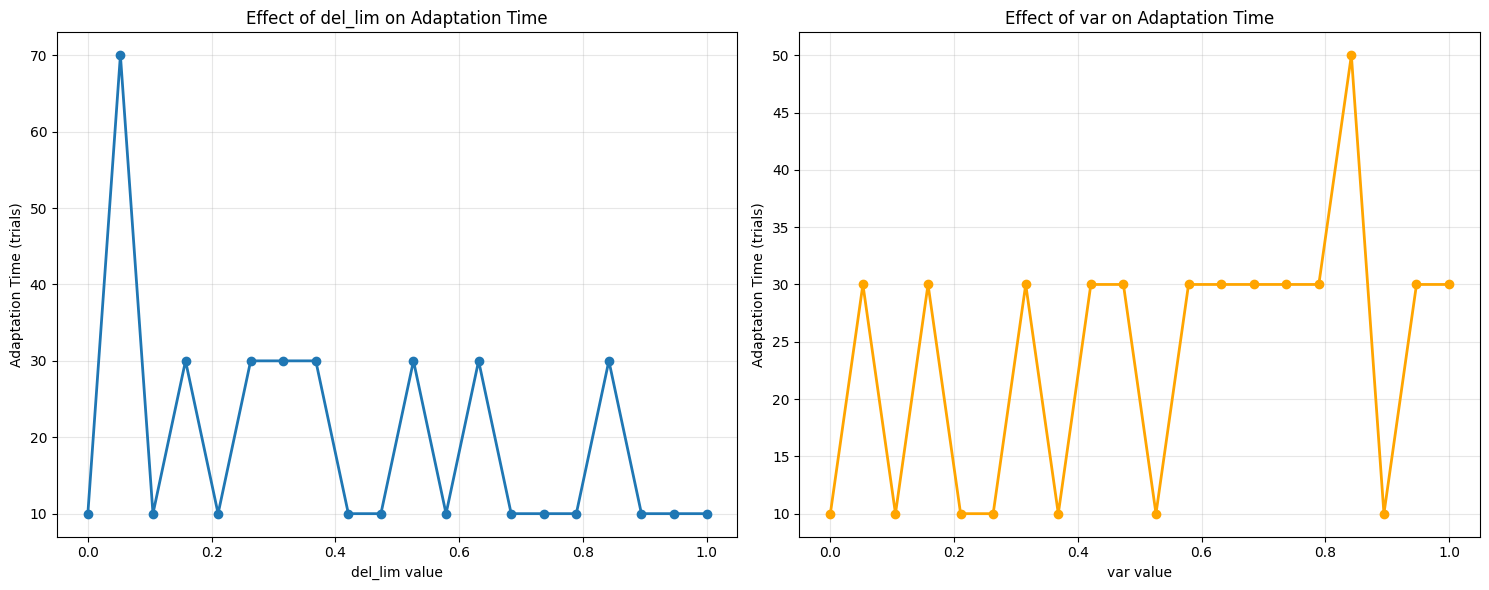

In [6]:
# Extract adaptation times for del_lim sweep
del_lim_adapt_times = []
del_lim_values_valid = []

for del_lim in del_lim_values:
    adapt_data = results['del_lim'][del_lim]['adaptation']
    if adapt_data['adapted']:
        del_lim_values_valid.append(del_lim)
        del_lim_adapt_times.append(adapt_data['adaptation_time'])

# Extract adaptation times for var sweep
var_adapt_times = []
var_values_valid = []

for var in var_values:
    adapt_data = results['var'][var]['adaptation']
    if adapt_data['adapted']:
        var_values_valid.append(var)
        var_adapt_times.append(adapt_data['adaptation_time'])

# Plot adaptation times vs parameters
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(del_lim_values_valid, del_lim_adapt_times, 'o-', linewidth=2)
plt.xlabel('del_lim value')
plt.ylabel('Adaptation Time (trials)')
plt.title('Effect of del_lim on Adaptation Time')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(var_values_valid, var_adapt_times, 'o-', linewidth=2, color='orange')
plt.xlabel('var value')
plt.ylabel('Adaptation Time (trials)')
plt.title('Effect of var on Adaptation Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Results Analysis: Arm Selection Probabilities

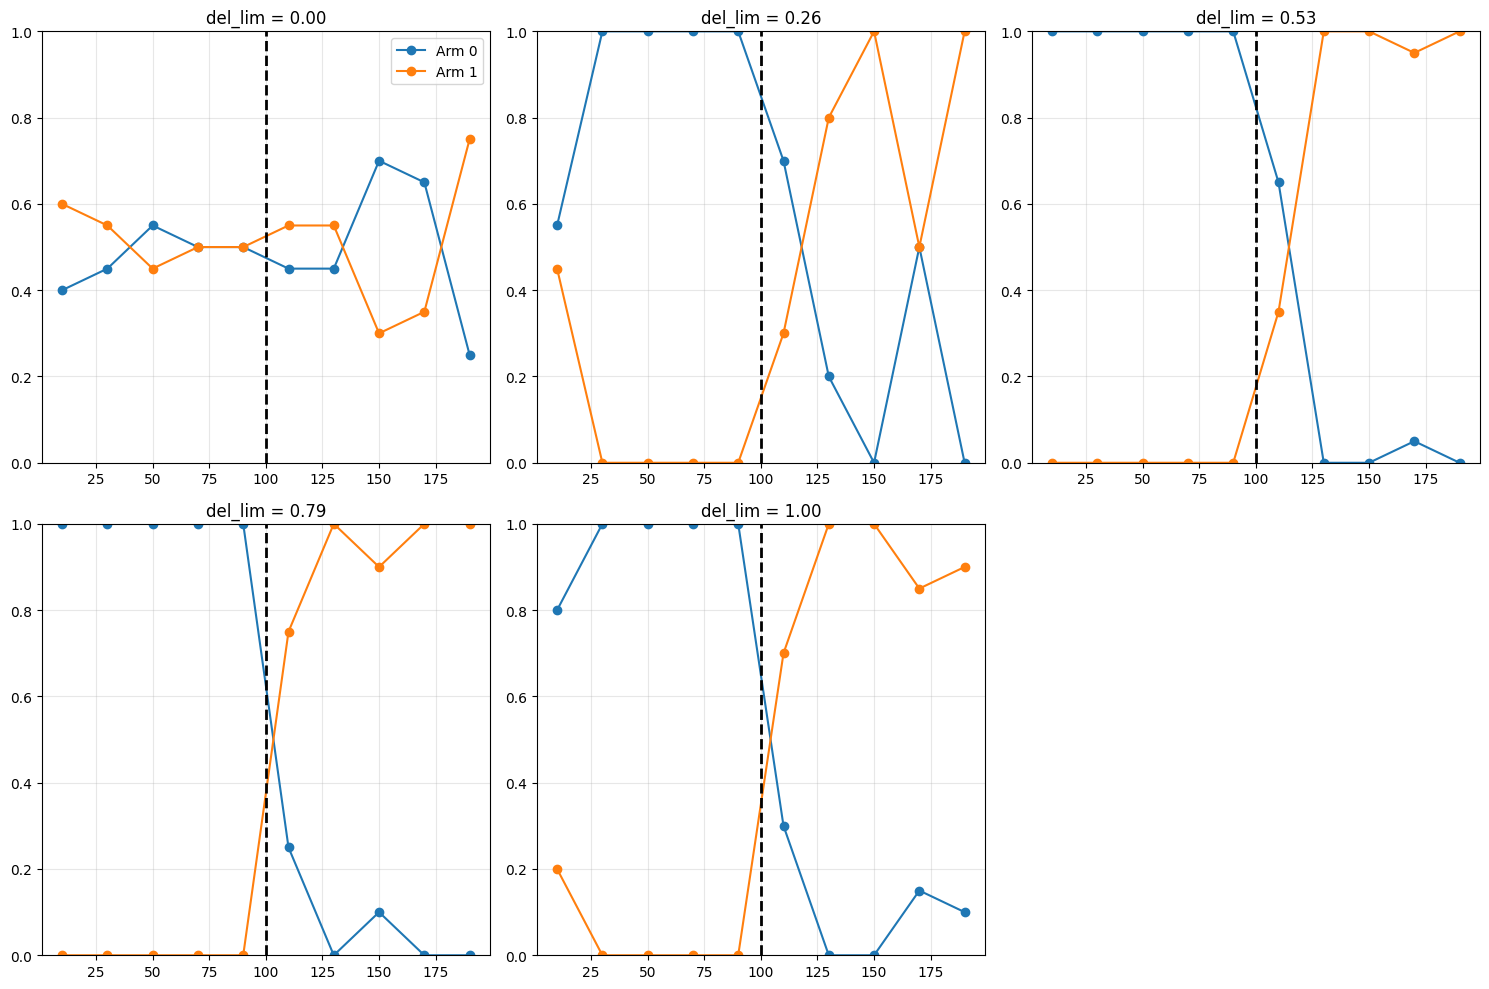

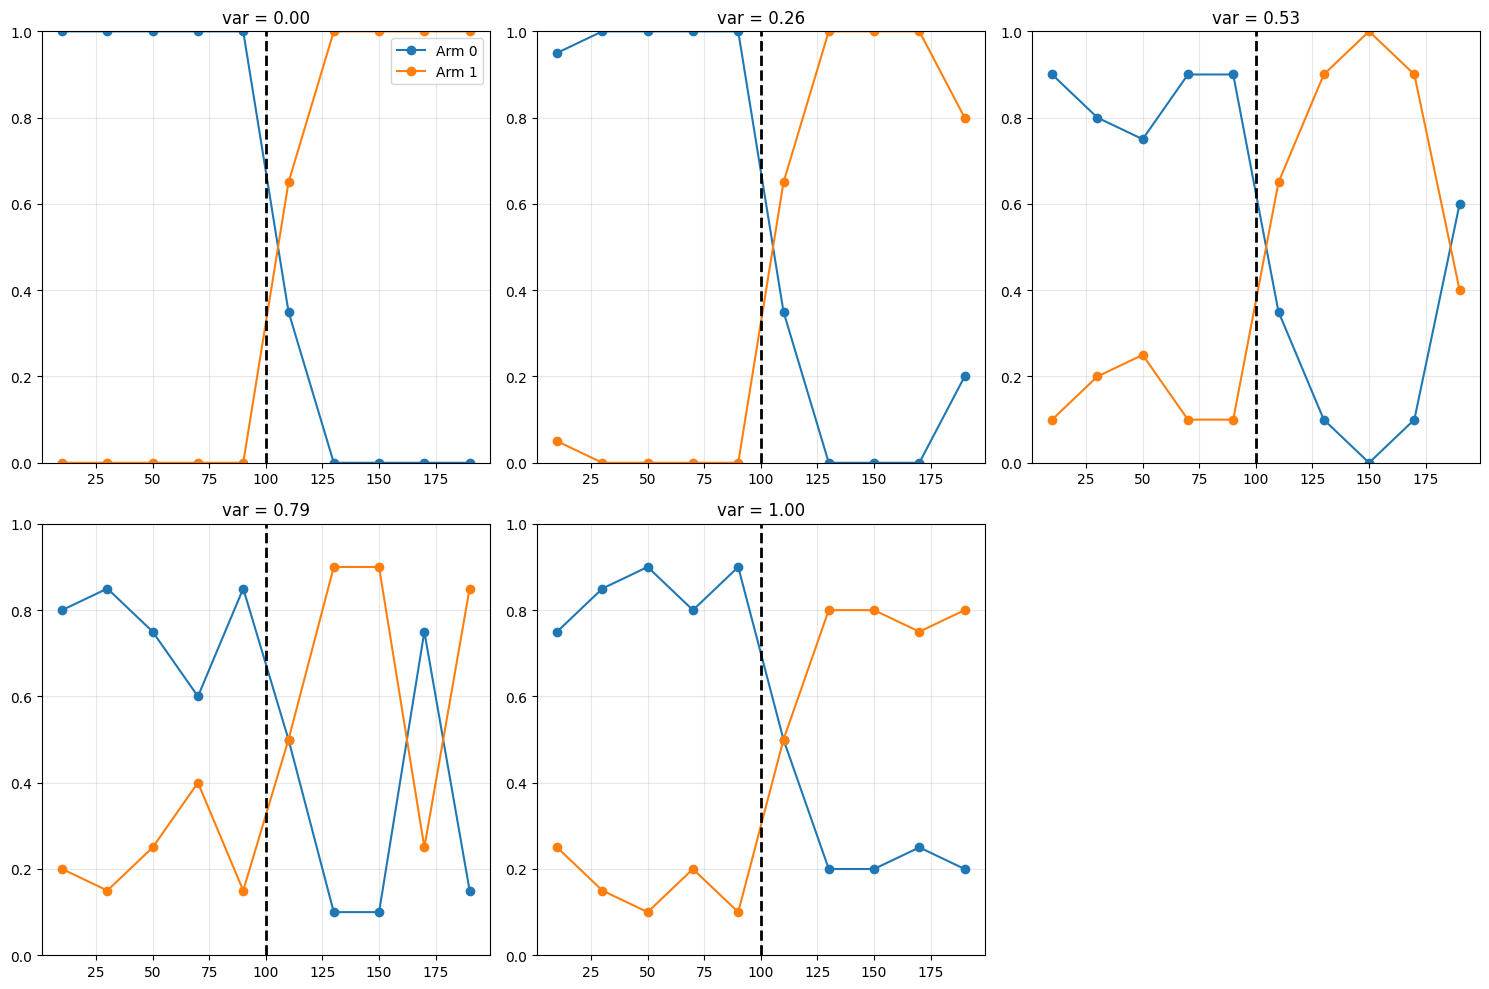

In [7]:
# Plot arm probabilities for selected del_lim values
plt.figure(figsize=(15, 10))

# Select a few del_lim values to visualize
del_lim_to_show = [del_lim_values[0], del_lim_values[5], del_lim_values[10], del_lim_values[15], del_lim_values[-1]]

for i, del_lim in enumerate(del_lim_to_show):
    plt.subplot(2, 3, i+1)
    data = results['del_lim'][del_lim]
    window_centers = data['window_centers']
    
    for arm in range(num_arms):
        plt.plot(window_centers, data['arm_probs'][arm], 
                 marker='o', linestyle='-', label=f'Arm {arm}')
    
    plt.axvline(x=time_stamp_change, color='black', linestyle='--', linewidth=2)
    plt.title(f'del_lim = {del_lim:.2f}')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Plot arm probabilities for selected var values
plt.figure(figsize=(15, 10))

# Select a few var values to visualize
var_to_show = [var_values[0], var_values[5], var_values[10], var_values[15], var_values[-1]]

for i, var in enumerate(var_to_show):
    plt.subplot(2, 3, i+1)
    data = results['var'][var]
    window_centers = data['window_centers']
    
    for arm in range(num_arms):
        plt.plot(window_centers, data['arm_probs'][arm], 
                 marker='o', linestyle='-', label=f'Arm {arm}')
    
    plt.axvline(x=time_stamp_change, color='black', linestyle='--', linewidth=2)
    plt.title(f'var = {var:.2f}')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

## Heat Map Visualization

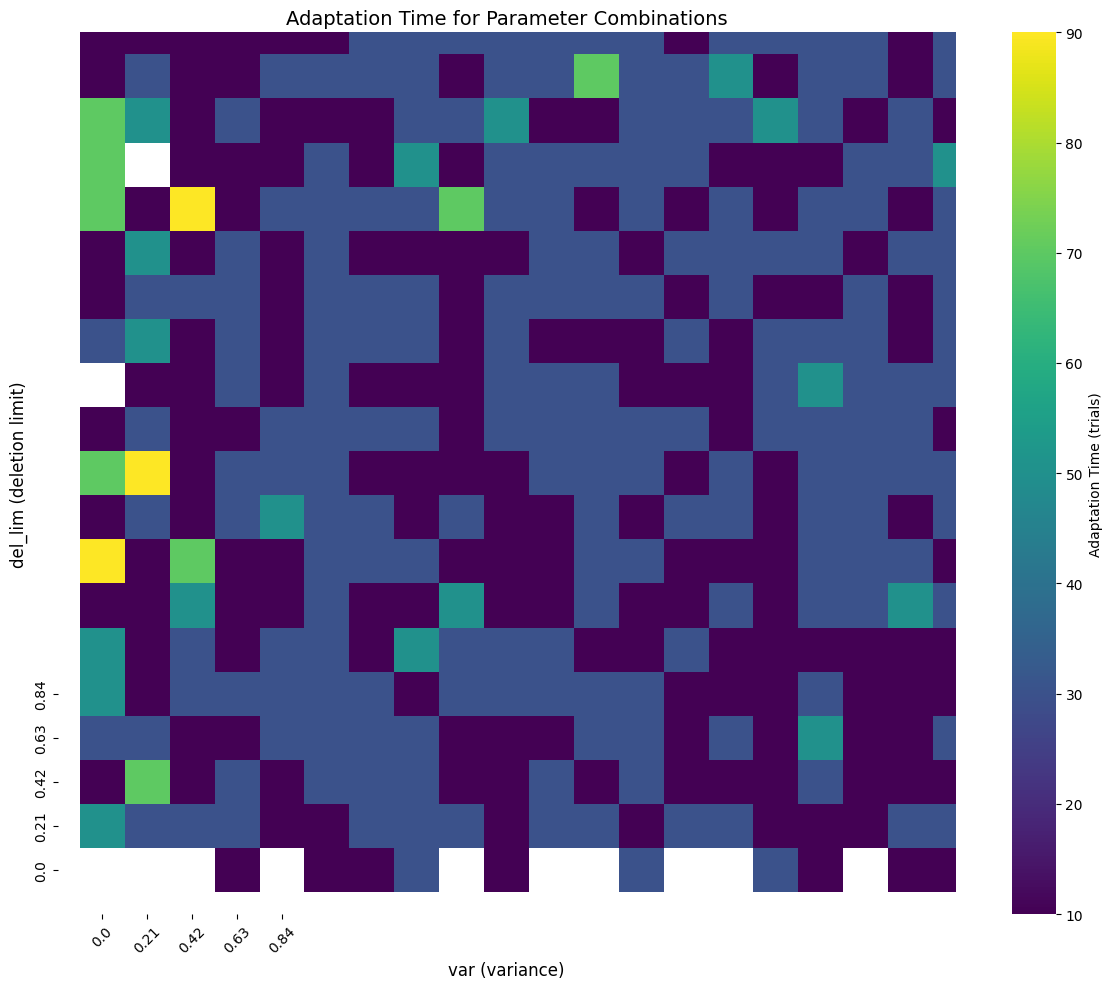

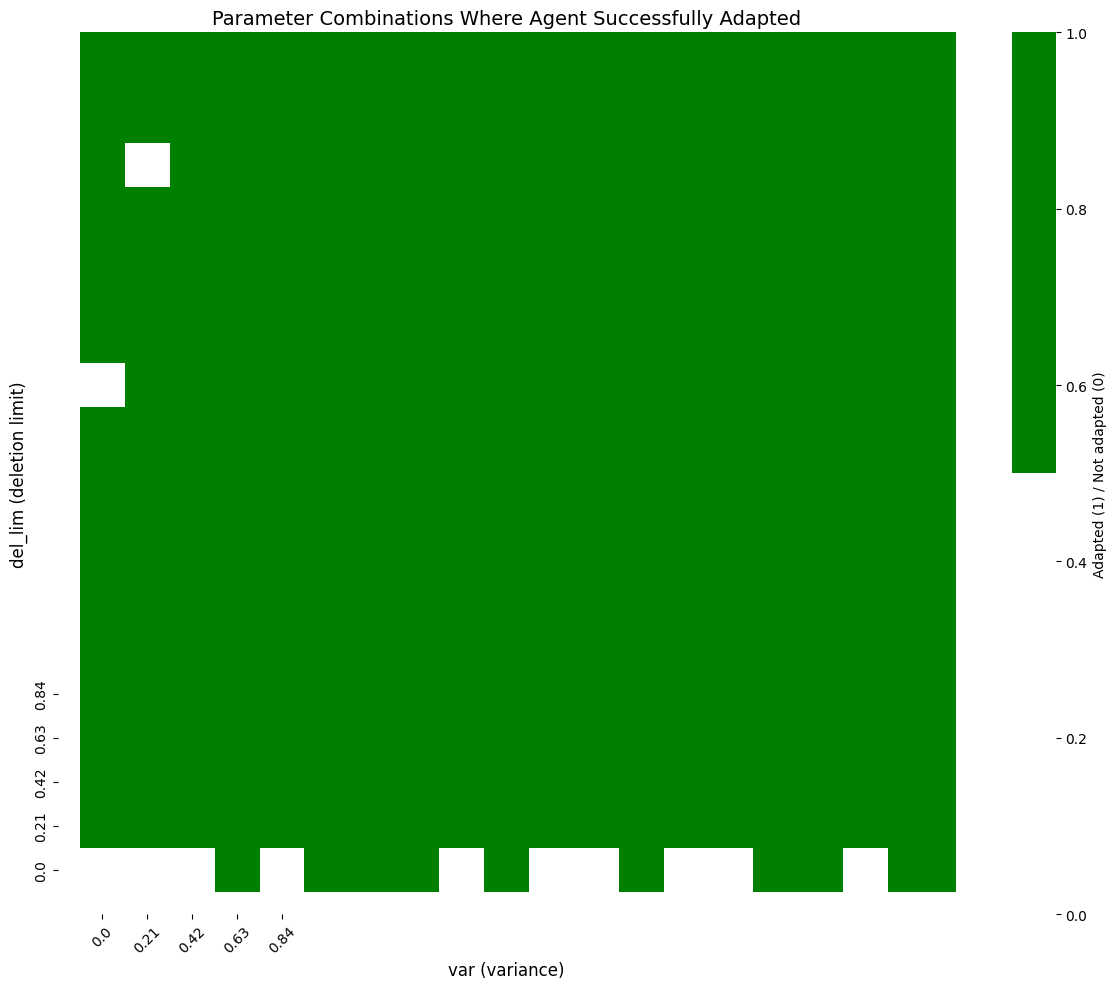

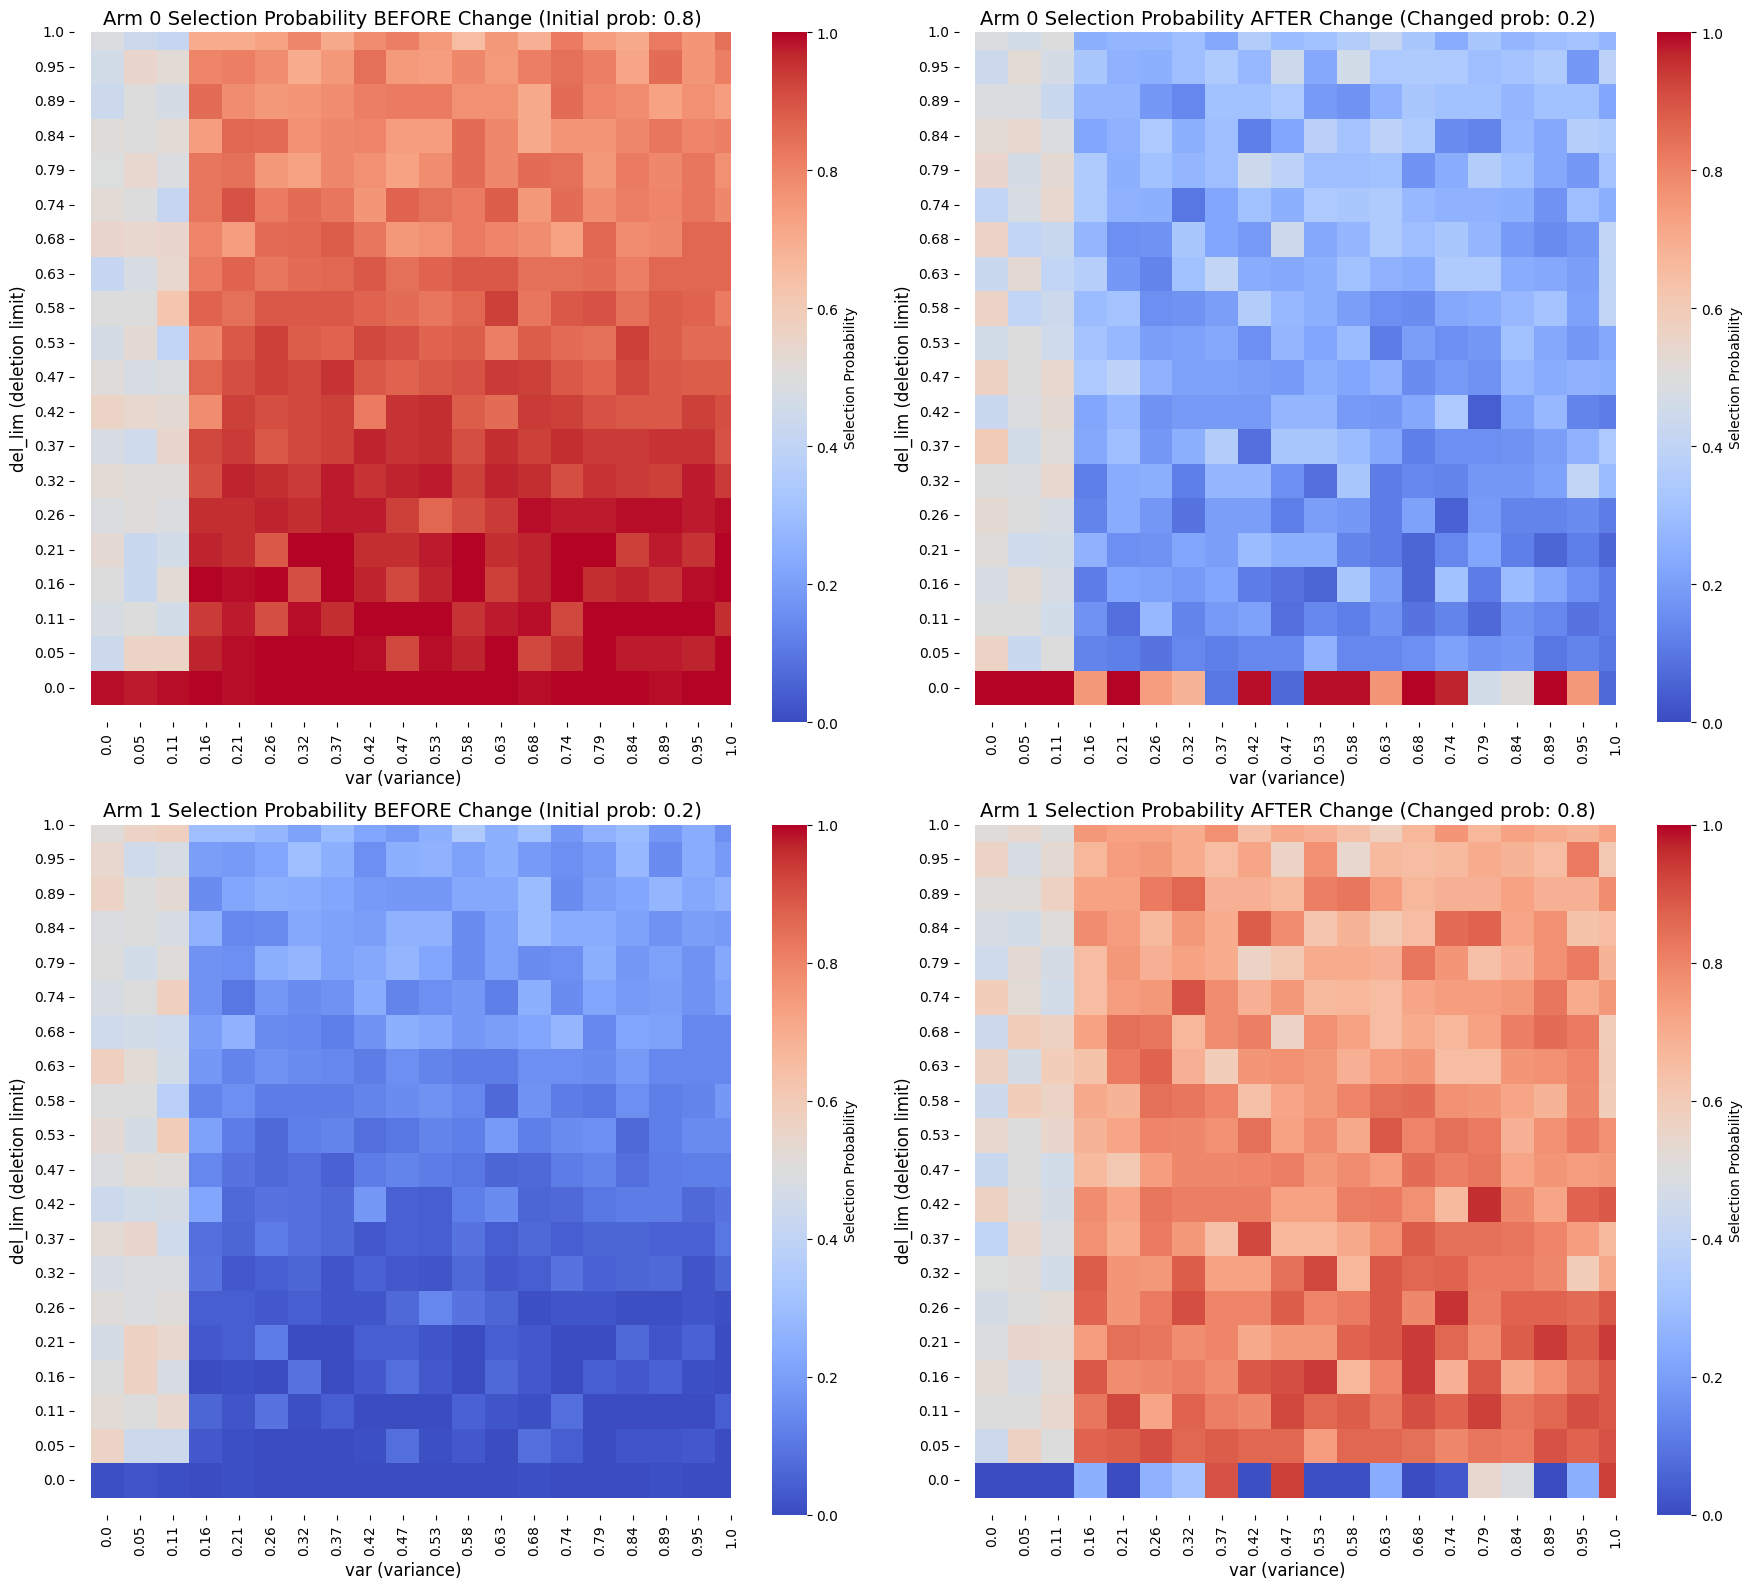

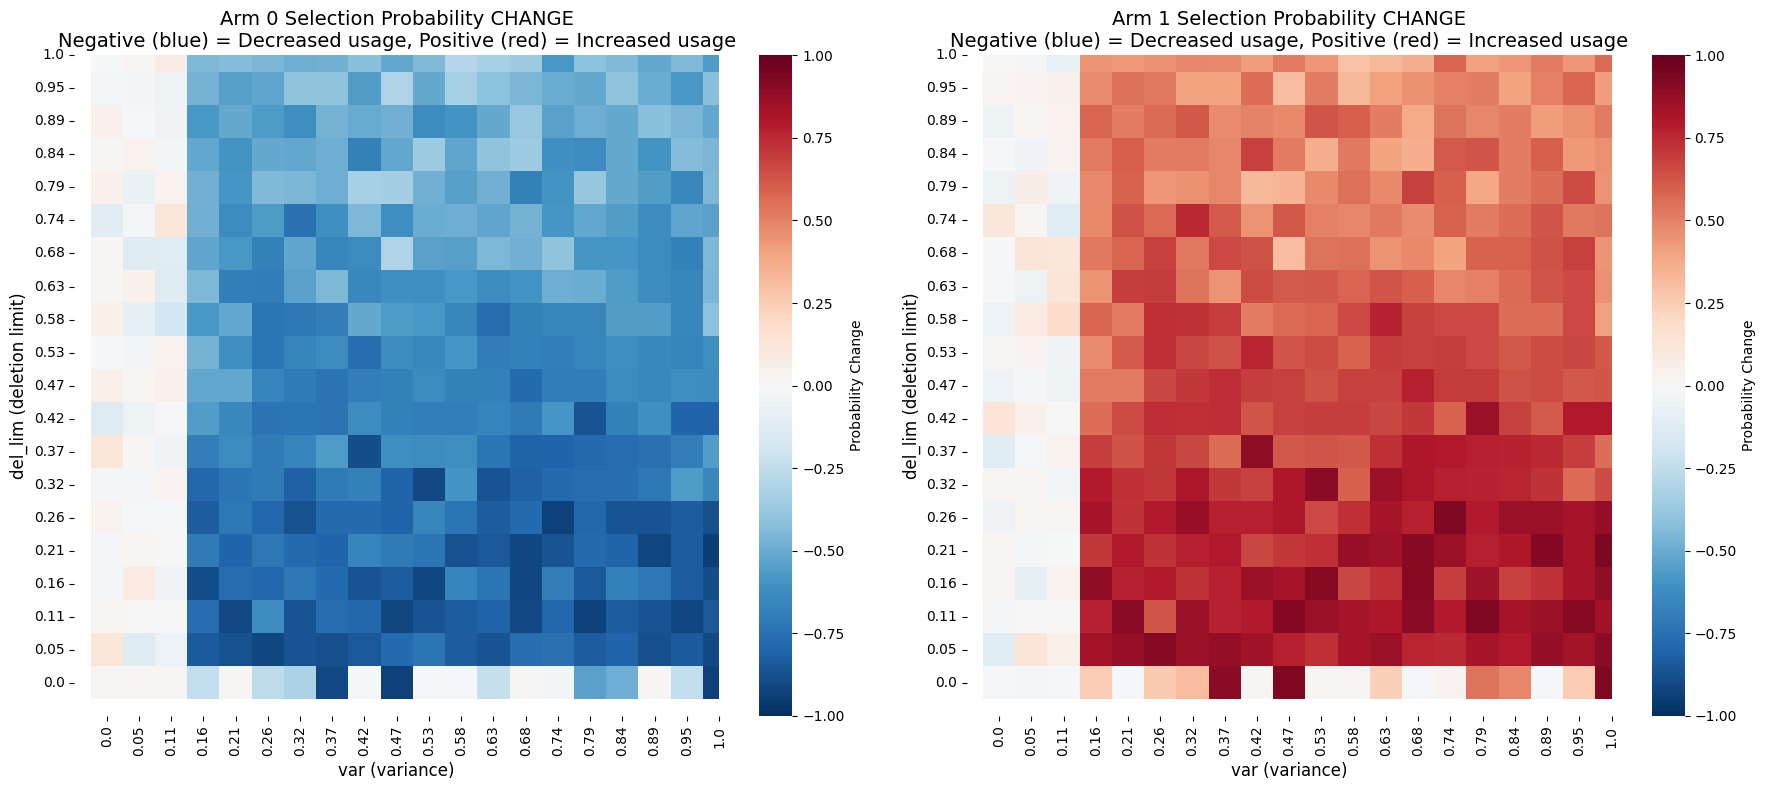

In [ ]:
# Create a matrix to store adaptation times for different parameter combinations
adaptation_matrix = np.zeros((len(del_lim_values), len(var_values)))
adaptation_matrix.fill(np.nan)  # Fill with NaN for unadapted cases

# Populate the matrix from our 2D results
for i, del_lim in enumerate(del_lim_values):
    for j, var in enumerate(var_values):
        adapt_data = results_2d[del_lim][var]['adaptation']
        if adapt_data['adapted']:
            adaptation_matrix[i, j] = adapt_data['adaptation_time']

# Transpose the matrix for proper orientation (del_lim on y-axis, var on x-axis)
adaptation_matrix = adaptation_matrix.T

# Replace NaN values in adaptation_matrix with -1 for visualization
adaptation_matrix = np.nan_to_num(adaptation_matrix, nan=-1)

# Verify matrix dimensions
assert adaptation_matrix.shape == (len(var_values), len(del_lim_values)), "Adaptation matrix dimensions mismatch"

# Create heatmap for adaptation time
plt.figure(figsize=(12, 10))
ax = sns.heatmap(adaptation_matrix, 
                xticklabels=np.round(var_values, 2),
                yticklabels=np.round(del_lim_values, 2),
                cmap="viridis", 
                cbar_kws={'label': 'Adaptation Time (trials)'},
                mask=(adaptation_matrix == -1))
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title('Adaptation Time for Parameter Combinations', fontsize=14)
plt.xticks(rotation=45)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)
plt.tight_layout()
plt.savefig("adaptation_time_heatmap.png")  # Save heatmap for later use
plt.show()

# Create a binary matrix showing which parameter combinations resulted in adaptation
adapted_matrix = np.zeros((len(del_lim_values), len(var_values)))

# Populate the matrix
for i, del_lim in enumerate(del_lim_values):
    for j, var in enumerate(var_values):
        adapted_matrix[i, j] = results_2d[del_lim][var]['adaptation']['adapted']

# Transpose the matrix for proper orientation (del_lim on y-axis, var on x-axis)
adapted_matrix = adapted_matrix.T

# Verify matrix dimensions
assert adapted_matrix.shape == (len(var_values), len(del_lim_values)), "Adapted matrix dimensions mismatch"

# Create heatmap showing adapted vs. not adapted
plt.figure(figsize=(12, 10))
ax = sns.heatmap(adapted_matrix, 
                xticklabels=np.round(var_values, 2),
                yticklabels=np.round(del_lim_values, 2),
                cmap=["white", "green"],
                cbar_kws={'label': 'Adapted (1) / Not adapted (0)'},
                vmin=0, vmax=1)
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title('Parameter Combinations Where Agent Successfully Adapted', fontsize=14)
plt.xticks(rotation=45)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)
plt.tight_layout()
plt.savefig("adapted_combinations_heatmap.png")  # Save heatmap for later use
plt.show()

# Arm probability heatmaps (4 plots - 2 arms, before and after change)
plt.figure(figsize=(18, 16))

# Transpose matrices for proper orientation
arm0_pre_matrix = arm0_pre_matrix.T
arm0_post_matrix = arm0_post_matrix.T
arm1_pre_matrix = arm1_pre_matrix.T
arm1_post_matrix = arm1_post_matrix.T

# Verify matrix dimensions
assert arm0_pre_matrix.shape == (len(var_values), len(del_lim_values)), "Arm 0 pre matrix dimensions mismatch"
assert arm0_post_matrix.shape == (len(var_values), len(del_lim_values)), "Arm 0 post matrix dimensions mismatch"
assert arm1_pre_matrix.shape == (len(var_values), len(del_lim_values)), "Arm 1 pre matrix dimensions mismatch"
assert arm1_post_matrix.shape == (len(var_values), len(del_lim_values)), "Arm 1 post matrix dimensions mismatch"

# Arm 0 pre-change
plt.subplot(2, 2, 1)
ax0_pre = sns.heatmap(arm0_pre_matrix, 
                    xticklabels=np.round(var_values, 2),
                    yticklabels=np.round(del_lim_values, 2),
                    cmap="coolwarm", 
                    cbar_kws={'label': 'Selection Probability'},
                    vmin=0, vmax=1)
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title(f'Arm 0 Selection Probability BEFORE Change (Initial prob: {initial_probabilities[0]})', fontsize=14)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)

# Arm 0 post-change
plt.subplot(2, 2, 2)
ax0_post = sns.heatmap(arm0_post_matrix, 
                     xticklabels=np.round(var_values, 2),
                     yticklabels=np.round(del_lim_values, 2),
                     cmap="coolwarm", 
                     cbar_kws={'label': 'Selection Probability'},
                     vmin=0, vmax=1)
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title(f'Arm 0 Selection Probability AFTER Change (Changed prob: {changed_probabilities[0]})', fontsize=14)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)

# Arm 1 pre-change
plt.subplot(2, 2, 3)
ax1_pre = sns.heatmap(arm1_pre_matrix, 
                    xticklabels=np.round(var_values, 2),
                    yticklabels=np.round(del_lim_values, 2),
                    cmap="coolwarm", 
                    cbar_kws={'label': 'Selection Probability'},
                    vmin=0, vmax=1)
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title(f'Arm 1 Selection Probability BEFORE Change (Initial prob: {initial_probabilities[1]})', fontsize=14)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)

# Arm 1 post-change
plt.subplot(2, 2, 4)
ax1_post = sns.heatmap(arm1_post_matrix, 
                     xticklabels=np.round(var_values, 2),
                     yticklabels=np.round(del_lim_values, 2),
                     cmap="coolwarm", 
                     cbar_kws={'label': 'Selection Probability'},
                     vmin=0, vmax=1)
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title(f'Arm 1 Selection Probability AFTER Change (Changed prob: {changed_probabilities[1]})', fontsize=14)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)

plt.tight_layout()
plt.show()

# Calculate difference between pre and post change
arm0_diff_matrix = arm0_post_matrix - arm0_pre_matrix
arm1_diff_matrix = arm1_post_matrix - arm1_pre_matrix

# Plot the differences
plt.figure(figsize=(18, 8))

# Arm 0 difference
plt.subplot(1, 2, 1)
ax0_diff = sns.heatmap(arm0_diff_matrix, 
                     xticklabels=np.round(var_values, 2),
                     yticklabels=np.round(del_lim_values, 2),
                     cmap="RdBu_r", 
                     cbar_kws={'label': 'Probability Change'},
                     vmin=-1, vmax=1, center=0)
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title(f'Arm 0 Selection Probability CHANGE\nNegative (blue) = Decreased usage, Positive (red) = Increased usage', fontsize=14)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)

# Arm 1 difference
plt.subplot(1, 2, 2)
ax1_diff = sns.heatmap(arm1_diff_matrix, 
                     xticklabels=np.round(var_values, 2),
                     yticklabels=np.round(del_lim_values, 2),
                     cmap="RdBu_r", 
                     cbar_kws={'label': 'Probability Change'},
                     vmin=-1, vmax=1, center=0)
plt.xlabel('var (variance)', fontsize=12)
plt.ylabel('del_lim (deletion limit)', fontsize=12)
plt.title(f'Arm 1 Selection Probability CHANGE\nNegative (blue) = Decreased usage, Positive (red) = Increased usage', fontsize=14)
# Display full range of ticks
plt.xlim(-0.5, len(var_values) - 0.5)
plt.ylim(-0.5, len(del_lim_values) - 0.5)

plt.tight_layout()
plt.show()

Validating heatmap matrices...
Adaptation matrix shape: (20, 20)
Adapted matrix shape: (20, 20)
Arm 0 pre matrix shape: (20, 20)
Arm 0 post matrix shape: (20, 20)
Arm 1 pre matrix shape: (20, 20)
Arm 1 post matrix shape: (20, 20)
NaN values in adaptation matrix: 0
NaN values in adapted matrix: 0
NaN values in arm0_pre_matrix: 0
NaN values in arm0_post_matrix: 0
NaN values in arm1_pre_matrix: 0
NaN values in arm1_post_matrix: 0


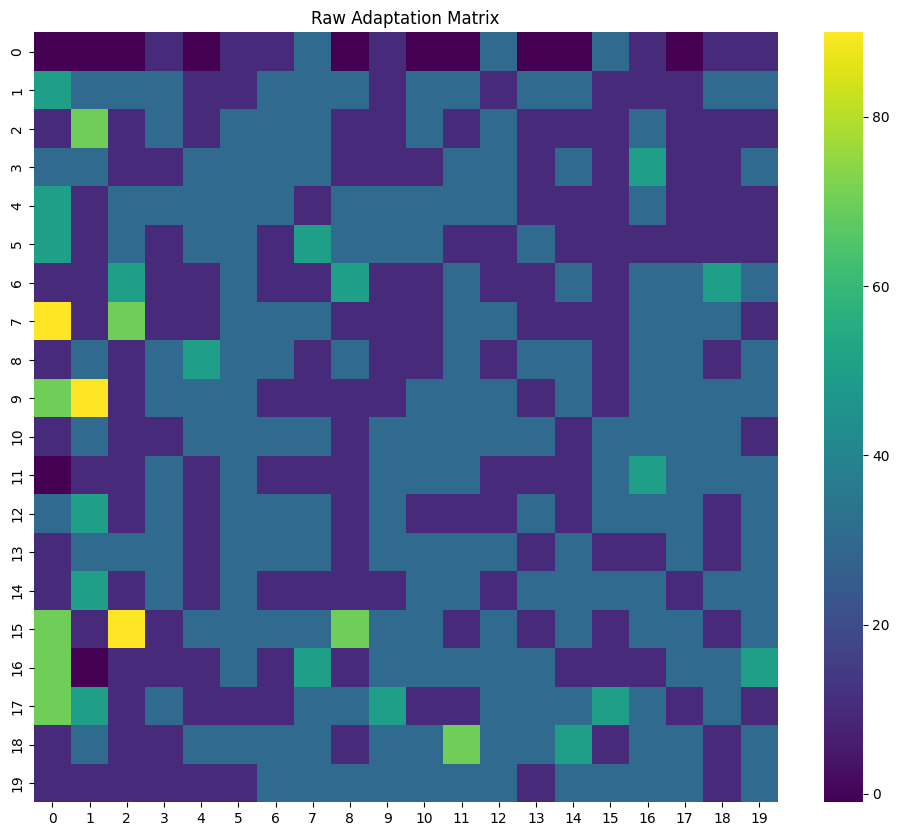

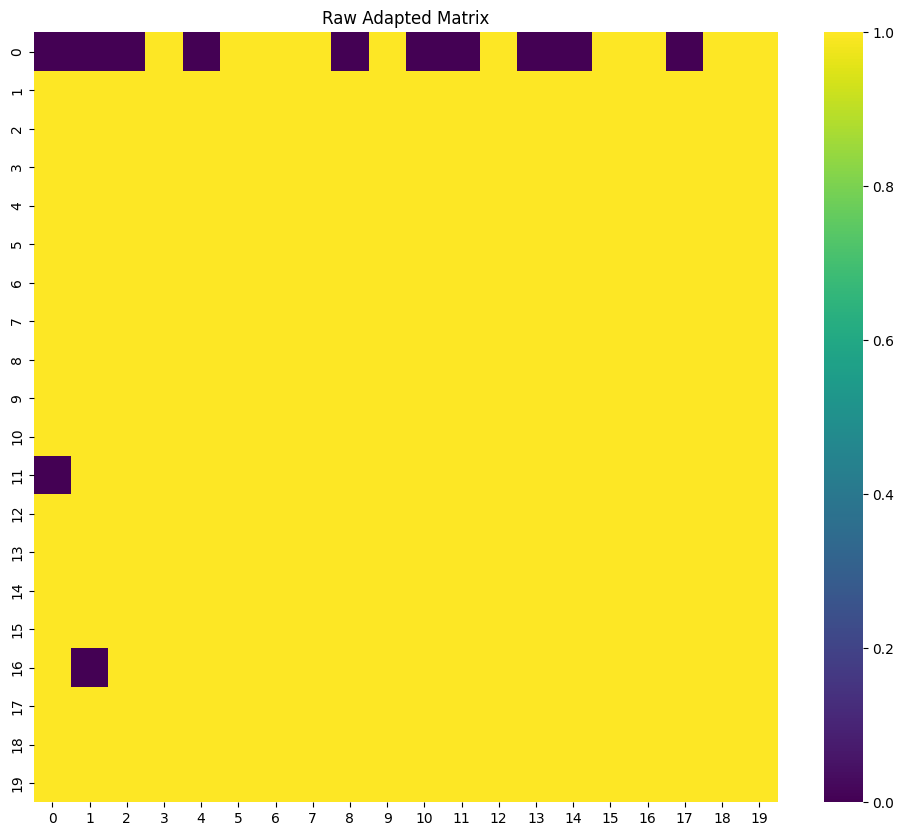

Verifying axis limits and tick labels...
X-axis limits: (np.float64(0.0), np.float64(1.0))
Y-axis limits: (np.float64(0.0), np.float64(1.0))
X-axis tick labels: [0.   0.05 0.11 0.16 0.21 0.26 0.32 0.37 0.42 0.47 0.53 0.58 0.63 0.68
 0.74 0.79 0.84 0.89 0.95 1.  ]
Y-axis tick labels: [0.   0.05 0.11 0.16 0.21 0.26 0.32 0.37 0.42 0.47 0.53 0.58 0.63 0.68
 0.74 0.79 0.84 0.89 0.95 1.  ]


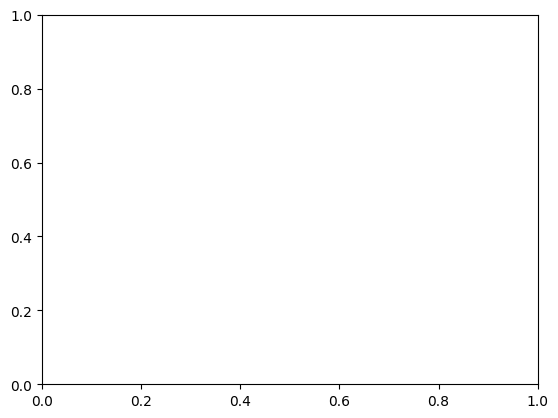

In [12]:
# Debugging: Validate Heatmap Matrices and Axis Alignment
print("Validating heatmap matrices...")
print(f"Adaptation matrix shape: {adaptation_matrix.shape}")
print(f"Adapted matrix shape: {adapted_matrix.shape}")
print(f"Arm 0 pre matrix shape: {arm0_pre_matrix.shape}")
print(f"Arm 0 post matrix shape: {arm0_post_matrix.shape}")
print(f"Arm 1 pre matrix shape: {arm1_pre_matrix.shape}")
print(f"Arm 1 post matrix shape: {arm1_post_matrix.shape}")

# Check for NaN values in matrices
print(f"NaN values in adaptation matrix: {np.isnan(adaptation_matrix).sum()}")
print(f"NaN values in adapted matrix: {np.isnan(adapted_matrix).sum()}")
print(f"NaN values in arm0_pre_matrix: {np.isnan(arm0_pre_matrix).sum()}")
print(f"NaN values in arm0_post_matrix: {np.isnan(arm0_post_matrix).sum()}")
print(f"NaN values in arm1_pre_matrix: {np.isnan(arm1_pre_matrix).sum()}")
print(f"NaN values in arm1_post_matrix: {np.isnan(arm1_post_matrix).sum()}")

# Debugging: Visualize raw matrix data
plt.figure(figsize=(12, 10))
plt.title("Raw Adaptation Matrix")
sns.heatmap(adaptation_matrix, cmap="viridis", cbar=True)
plt.show()

plt.figure(figsize=(12, 10))
plt.title("Raw Adapted Matrix")
sns.heatmap(adapted_matrix, cmap="viridis", cbar=True)
plt.show()

# Debugging: Verify axis limits and tick labels
print("Verifying axis limits and tick labels...")
print(f"X-axis limits: {plt.xlim()}")
print(f"Y-axis limits: {plt.ylim()}")
print(f"X-axis tick labels: {np.round(var_values, 2)}")
print(f"Y-axis tick labels: {np.round(del_lim_values, 2)}")